In [ ]:
#| default_exp glssm

In [ ]:
#| export
import jax.numpy as jnp
import jax.random as jrn
from jax import vmap
from jax.lax import scan
from jaxtyping import Array, Float, PRNGKeyArray

from isssm.kalman import kalman
from isssm.typing import (GLSSM, GLSSMObservationModel, GLSSMState,
                          Observations, States)
from isssm.util import MVN_degenerate as MVN

In [ ]:
#| hide
# use x86 for testing purposes
import jax
import matplotlib.pyplot as plt
from isssm.kalman import kalman, smoother
import fastcore.test as fct

In [ ]:
# use x86 for testing purposes
jax.config.update("jax_enable_x64", True)

# Gaussian Linear State Space Models
> Simulation and components

Consider a gaussian state space model of the form
$$
\begin{align*}
    X_0 &\sim \mathcal N (x_0, \Sigma_0) &\\
    X_{t + 1} &= A_t X_{t} + \varepsilon_{t + 1} &t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) & t = 1, \dots, n \\
    Y_t &= B_t X_t + \eta_t & t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_t) & t=0, \dots, n.
\end{align*}
$$
As the joint distribution of $(X_0, \dots, X_n, Y_0, \dots, Y_n)$ is gaussian, we call it a **G**aussian **l**inear  **s**tate **s**pace **m**odel (GLSSM).

## Sampling from the joint distribution
To obtain a sample $(X_0, \dots, X_n), (Y_0, \dots, Y_n)$ we first simulate from the joint distribution of the states and then, as observations are coniditionally independent of one another given the states, simulate all states at once.

In [ ]:
# | export

vmatmul = vmap(jnp.matmul, (None, 0))

def simulate_states(
    state: GLSSMState,
    N: int, # number of samples to draw
    key: PRNGKeyArray # the random state
) -> Float[Array, "N n+1 m"]: # array of N samples from the state distribution  
    """Simulate states of a GLSSM """
    x0, A, Sigma = state

    def sim_next_states(carry, inputs):
        x_prev, key = carry
        A, Sigma = inputs

        next_loc = vmatmul(A, x_prev)

        key, subkey = jrn.split(key)
        samples = MVN(next_loc, Sigma).sample(seed=subkey)

        return (samples, key), samples

    (m,) = x0.shape
    A_ext = jnp.concatenate((jnp.eye(m)[jnp.newaxis], A))

    x0_recast = jnp.broadcast_to(x0, (N, m))
    key, subkey = jrn.split(key)

    _, X = scan(sim_next_states, (x0_recast, subkey), (A_ext, Sigma))

    return X.transpose((1, 0, 2))

In [ ]:
#| export

def simulate_glssm(
    glssm: GLSSM,
    N: int, # number of sample paths
    key: PRNGKeyArray # the random state
) -> (Float[Array, "N n+1 m"], Float[Array, "N n+1 p"]): # tuple of two arrays each with of N samples from the state/observation distribution
    """Simulate states and observations of a GLSSM """
    x0, A, Sigma, B, Omega = glssm
    key, subkey = jrn.split(key)
    X = simulate_states(GLSSMState(x0, A, Sigma), N, subkey).transpose((1, 0, 2))

    S = vmap(vmatmul, (0, 0))(B, X)

    # samples x time x space
    X = X.transpose((1, 0, 2))

    S = S.transpose((1, 0, 2))

    key, subkey = jrn.split(key)
    Y = MVN(S, Omega).sample(seed=subkey)

    return X, Y

In [ ]:
m, p, n = 3, 2, 100
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2, omega2 = 1, 1
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
Omega = jnp.broadcast_to(omega2 * jnp.eye(p), (n + 1, p, p))
x0 = jnp.zeros(m)

key = jrn.PRNGKey(53412312)
key, subkey = jrn.split(key)
(X, ), (Y,) = simulate_glssm(GLSSM(x0, A, Sigma, B, Omega), 1, subkey)

In [ ]:
#| hide
fct.test_eq(X.shape, (n+1,m))
fct.test_eq(Y.shape, (n+1,p))

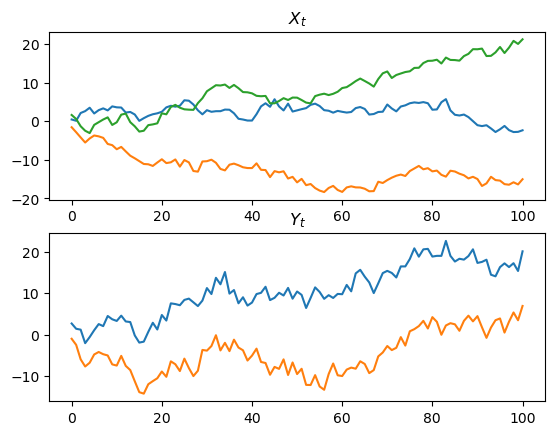

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title("$X_t$")
ax1.plot(X)

ax2.set_title("$Y_t$")
ax2.plot(Y)
plt.show()

## Sampling from the smoothing distribution

After having run the Kalman filter we can use a recursion due to Frühwirth-Schnatter [@Fruhwirth-Schnatter1994Data] to obtain samples from the joint conditional distribution the states given observations.

By the dependency structure of states and observations the conditional densities can be factorized in the following way:

$$
\begin{align*}
p(x_0, \dots, x_n | y_0, \dots, y_n) &=  p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, \dots, x_n, y_0, \dots, y_n) \\
&= p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, y_0, \dots, y_n)
\end{align*}
$$

and the conditional distributions are again gaussian with conditional expecatation 
$$
\mathbf E (X_{t} | X_{t + 1}, Y_0, \dots, Y_n) = \hat X_{t|t} + G_t (X_{t + 1} - \hat X_{t + 1|t})
$$ and conditional covariance matrix 
$$
\text{Cov} (X_t | X_{t + 1}, Y_0, \dots, Y_n) = \Xi_{t|t} - G_t\Xi_{t + 1 | t} G_t^T
$$

where $G_t = \Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1}$ is the smoothing gain.

In [ ]:
# | export
def simulate_smoothed_FW1994(
    x_filt: Float[Array, "n+1 m"],
    Xi_filt: Float[Array, "n+1 m m"],
    Xi_pred: Float[Array, "n+1 m m"],
    A: Float[Array, "n m m"],
    N: int, # number of samples
    key: PRNGKeyArray # the random states
) -> Float[Array, "N n+1 m"]: # array of N samples from the smoothing distribution
    r"""Simulate from smoothing distribution $p(X_0, \dots, X_n|Y_0, \dots, Y_n)$"""

    key, subkey = jrn.split(key)
    X_n = MVN(x_filt[-1], Xi_filt[-1]).sample(N, subkey)

    def sample_backwards(carry, inputs):
        X_smooth_next, key = carry
        x_filt, Xi_filt, Xi_pred, A = inputs

        G = Xi_filt @ jnp.linalg.solve(Xi_pred, A).T

        cond_expectation = x_filt + vmatmul(G, X_smooth_next - (A @ x_filt)[None])
        cond_covariance = Xi_filt - G @ Xi_pred @ G.T

        key, subkey = jrn.split(key)
        new_samples = MVN(cond_expectation, cond_covariance).sample(seed=subkey)
        return (new_samples, key), new_samples

    key, subkey = jrn.split(key)
    _, X = scan(
        sample_backwards,
        (X_n, subkey),
        (x_filt[:-1], Xi_filt[:-1], Xi_pred[1:], A),
        reverse=True,
    )

    X_full = jnp.concatenate((X, X_n[None]))

    return X_full.transpose((1, 0, 2))


def FFBS(
    y: Observations, # Observations $y$
    glssm: GLSSM, # GLSSM
    N: int, # number of samples 
    key: PRNGKeyArray # random state
) -> Float[Array, "N n+1 m"]: # N samples from the smoothing distribution
    r"""The Forward-Filter Backwards-Sampling Algorithm from [@Fruhwirth-Schnatter1994Data]."""

    x0, A, Sigma, B, Omega = glssm
    x_filt, Xi_filt, _, Xi_pred = kalman(y, GLSSM(x0, A, Sigma, B, Omega))

    key, subkey = jrn.split(key)
    return simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, A, N, subkey)

In [ ]:
filtered = kalman(Y, GLSSM(x0, A, Sigma, B, Omega))
x_filt, Xi_filt, x_pred, Xi_pred = filtered

key, subkey = jrn.split(key)
X_sim, = simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, A, 1, subkey)

assert X_sim.shape == (n + 1, m)

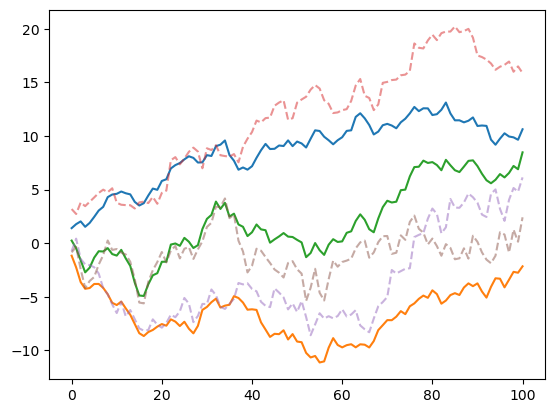

In [ ]:
x_smooth, Xi_smooth = smoother(filtered, A)

plt.plot(x_smooth)
plt.plot(X_sim, alpha=.5, linestyle="dashed")
plt.show()

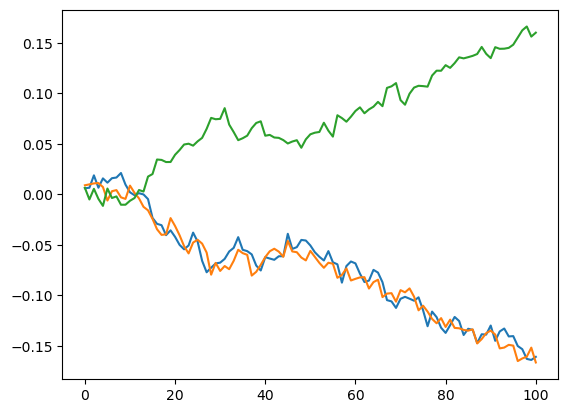

In [ ]:
#| hide
key, subkey = jrn.split(key)
X_sim = simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, A, 1e4, subkey)

plt.plot(X_sim.mean(axis = 0) - x_smooth)
plt.show()

## Joint Density

By the dependency structure of the model, the joint density factorizes as 

$$
p(x,y) = \prod_{t = 0}^n p(x_{t}| x_{t -1}) p(y_{t}|x_{t})
$$
where $p(x_0|x_{-1}) = p(x_0)$. The following functions return these components or evaluate the joint density directly.

In [ ]:
#| export
def log_probs_x(
    x: States,  # the states
    state: GLSSMState # the state model
) -> Float[Array, "n+1"]:  # log probabilities $p(x_t | x_{t-1})$
    """log probabilities $\\log p(x_t | x_{t-1})$"""
    x0, A, Sigma = state
    (m,) = x0.shape
    A_ext = jnp.concatenate((jnp.eye(m)[jnp.newaxis], A))
    x_prev = jnp.concatenate((x0[None], x[:-1]))
    x_pred = (A_ext @ x_prev[:, :, None])[:,:,0]
    return MVN(x_pred, Sigma).log_prob(x)


def log_probs_y(
    y: Observations,  # the observations
    x: States,  # the states
    obs_model: GLSSMObservationModel, # the observation model
) -> Float[Array, "n+1"]:  # log probabilities $p(y_t | x_t)$
    """log probabilities $\\log p(y_t | x_t)$"""
    B, Omega = obs_model
    y_pred = (B @ x[:, :, None])[:, :, 0]
    return MVN(y_pred, Omega).log_prob(y)

def log_prob(
    x: States,
    y: Observations,
    glssm: GLSSM
) -> Float: # $\\log p(x,y)$
    """joint log probability of states and observations"""
    x0, A, Sigma, B, Omega = glssm
    log_p_x = jnp.sum(log_probs_x(x, GLSSMState(x0, A, Sigma)))
    log_p_y_given_x = jnp.sum(log_probs_y(y, x, GLSSMObservationModel(B, Omega)))
    return log_p_x + log_p_y_given_x

In [ ]:
fct.test_eq(log_probs_x(X, GLSSMState(x0, A, Sigma)).shape, (n+1,))
fct.test_eq(log_probs_y(Y, X, GLSSMObservationModel(B, Omega)).shape, (n+1,))
fct.test_eq(log_prob(X, Y, GLSSM(x0, A, Sigma, B, Omega)).shape, ())

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()